# Cover Type Prediction of Forests
### Use cartographic variables to classify forest categories.

We're trying to predict the forest cover type based base on a training set of about 15k rows. **In this Notebook, no external data and daa leakage techniques we'll be used. THE TRAINING SET IS ALL WE NEED.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
%matplotlib inline

import seaborn as sns
# On indique à Seaborn d'afficher le cadre pour les légendes
sns.set()
sns.set_context("notebook", rc={"axes.titlesize": 18, "axes.labelsize": 15})
sns.set_color_codes()
sns.set_style({'legend.frameon': True})

work_dir = "C:/Users/Mauva/Documents/Work/SD701/Kaggle/"

After trying several algorithm without any tuning and feature engineering, we get a pretty good score with the ExtraTreesClassifier on train and cv data (splitted 70/30):
- train accuracy: **1**
- cv accuracy: **0.82407**

Let's try this on Kaggle:
- kaggle score: **0.58199**

It's not very satisfying, it seems that there is high variance in our model. What we can do now is to tune the hyperparameters of our model to reduce this variance.

**Grid search:**

*grid['n_estimators'] = [250,500,750,1000,1250,1500]*<br/>
*grid['max_features'] = [20,30,40]*<br/>
*grid['max_depth'] = [None]*<br/>

*gs = GridSearchCV(clf, param_grid=grid,cv=5)*


The grid search give us the below parameters:
- max_features = 40
- n_estimatores = 500


**Scores:**
- train accuracy: **1**
- cv accuracy: **0.87169**
- kaggle score: **0.66516**

With an ExtraTreesClassifier we've greatly reduced the variance, let's tackle the biais now by doing some feature engineering.

In [2]:
def feature_engineering(X):
    X_copy = X.copy()
    X_copy['Hillshade_mean'] = (
        X['Hillshade_9am'] + X['Hillshade_Noon'] + X['Hillshade_3pm']) / 3
    X_copy['log_elevation'] = np.log(X['Elevation'])
#     X_copy['Elevation_squared'] = X_copy['Elevation']**2
    X_copy['Ele_minus_VDtHyd'] = X_copy['Elevation'] - \
        X_copy['Vertical_Distance_To_Hydrology']

#     X_copy['Ele_minus_VDtHyd_squared'] = X_copy['Ele_minus_VDtHyd']**2
#     X_copy['Ele_plus_VDtHyd'] = X['Elevation'] + \
#         X['Vertical_Distance_To_Hydrology']
#     X_copy['Ele_minus_HDtHyd'] = X['Elevation'] - \
#         X['Horizontal_Distance_To_Hydrology']
#     X_copy['Ele_plus_HDtHyd'] = X['Elevation'] + \
#         X['Horizontal_Distance_To_Hydrology']
#     X_copy['Distance_to_Hydrolody'] = (X_copy['Horizontal_Distance_To_Hydrology']**2+X_copy['Vertical_Distance_To_Hydrology']**2)**0.5
    X_copy['Hydro_plus_Fire'] = X_copy['Horizontal_Distance_To_Hydrology'] + \
        X_copy['Horizontal_Distance_To_Fire_Points']
    X_copy['Hydro_plus_Fire_squared'] = X_copy['Hydro_plus_Fire']**2
    X_copy['Hydro_plus_Fire_cube'] = X_copy['Hydro_plus_Fire']**3
    X_copy['Hydro_plus_Fire_4'] = X_copy['Hydro_plus_Fire']**4
    X_copy['Hydro_minus_Fire'] = X_copy['Horizontal_Distance_To_Hydrology'] - \
        X_copy['Horizontal_Distance_To_Fire_Points']
    X_copy['Hydro_minus_Fire_squared'] = X_copy['Hydro_minus_Fire']**2
    X_copy['Hydro_minus_Fire_cube'] = X_copy['Hydro_minus_Fire']**3
#     X_copy['Hydro_minus_Fire_4']=X_copy['Hydro_minus_Fire']**4
    X_copy['Hydro_plus_Road'] = X_copy['Horizontal_Distance_To_Hydrology'] + \
        X_copy['Horizontal_Distance_To_Roadways']
    X_copy['Hydro_plus_Road_squared'] = X_copy['Hydro_plus_Road']**2
    X_copy['Hydro_plus_Road_cube'] = X_copy['Hydro_plus_Road']**3
#     X_copy['Hydro_plus_Road_4'] = X_copy['Hydro_plus_Road']**4
    X_copy['Hydro_minus_Road'] = abs(
        X_copy['Horizontal_Distance_To_Hydrology'] - X_copy['Horizontal_Distance_To_Roadways'])
    X_copy['Hydro_minus_Road_squared'] = X_copy['Hydro_minus_Road']**2
    X_copy['Hydro_minus_Road_cube'] = X_copy['Hydro_minus_Road']**3
    X_copy['Hydro_minus_Road_4'] = X_copy['Hydro_minus_Road']**4
    X_copy['Fire_plus_Road'] = X_copy['Horizontal_Distance_To_Fire_Points'] + \
        X_copy['Horizontal_Distance_To_Roadways']
    X_copy['Fire_plus_Road_squared'] = X_copy['Fire_plus_Road']**2
    X_copy['Fire_plus_Road_cube'] = X_copy['Fire_plus_Road']**3
    X_copy['Fire_plus_Road_4'] = X_copy['Fire_plus_Road']**4
    X_copy['Fire_minus_Road'] = X_copy['Horizontal_Distance_To_Fire_Points'] - \
        X_copy['Horizontal_Distance_To_Roadways']
#     X_copy['Fire_minus_Road_squared'] = X_copy['Fire_minus_Road']**2
    X_copy['Fire_minus_Road_cube'] = X_copy['Fire_minus_Road']**3
#     X_copy['Fire_minus_Road_4'] = X_copy['Fire_minus_Road']**4
#     X_copy['Aspect2']=X_copy['Aspect'].map(lambda x: map(x))
#     X_copy['S'] = np.where(X_copy["Vertical_Distance_To_Hydrology"] < 0,0,1)
    del X_copy['Aspect']
    del X_copy['Slope']
    del X_copy['Vertical_Distance_To_Hydrology']
    del X_copy['Elevation']
    X_copy.drop(X_copy.loc[:, 'Soil_Type1':'Soil_Type40'], axis=1)
    return X_copy

In [3]:
X = pd.read_csv(work_dir + "train-data.csv", sep=',', header=0)
X.set_index("Id", inplace=True)
# X=X[X['Cover_Type']!=4]

y = X['Cover_Type']
del X['Cover_Type']

# The Hillshade_3pm variable contains many zeros, it's seems that there're missing values. We're replacing them by the mean.
mean = X['Hillshade_3pm'].mean()
X['Hillshade_3pm'].loc[X['Hillshade_3pm'] == 0] = mean

X = feature_engineering(X)

Now that we have created some new features, let's do some hyperparameters tuning and try this on Kaggle:

**Feature Engineering: **
- max_features = 20
- n_estimatores = 1000
- cv accuracy: **0.90343**
- kaggle score: **0.74166**

It's a pretty good score compared to we had on our first try. Now we're going to look at the confusion matrix on our cross validation data to see how are the predictions in details.

**Confusion matrix:**<br/>
<pre>
[543,  92,   0,   0,  10,   2,  22]
[ 68, 525,  13,   0,  46,  13,   8]
[  0,   0, 565,  18,   2,  36,   0]
[  0,   0,   9, 575,   0,   5,   0]
[  0,   8,   5,   0, 643,   4,   0]
[  0,   2,  42,  10,   5, 641,   0]
[ 16,   2,   0,   0,   0,   0, 606]</pre>

It's seems that we're having some difficulties to distinguish class 1 from class 2 (and class 3 to a lesser extent).
We need to focus on these 2 classes, to be able to this, we're going to use a One-vs-Rest strategy:
- train class 7 vs rest, predict on test set and remove the rows predicted as class 7.
- train class 6 vs rest, predict on test set and remove the rows predicted as class 6.
- train class 5 vs rest, predict on test set and remove the rows predicted as class 5.
- train class 4 vs rest, predict on test set and remove the rows predicted as class 4.


In [4]:
# clf = ExtraTreesClassifier(random_state=100, n_jobs=4, bootstrap=False)
# grid={}
# grid['criterion'] = ['gini','entropy']
# grid['n_estimators'] = [250,500,750,1000,1250,1500]
# grid['max_features'] = [20,30,40]
# grid['max_depth']=[None]
# gs = GridSearchCV(clf, param_grid=grid,cv=5)
gs = ExtraTreesClassifier(random_state=100, n_jobs=4,
                          bootstrap=False, n_estimators=1000, max_features=20)


def oredered_OvR(X_train, y_train, X_test, grid_search):
    y_test = pd.DataFrame(X_test.index, columns=["Id"])
    model = gs.fit(X_train, y_train)
    df_predictions = pd.DataFrame(gs.predict(X_test), columns=["Cover_Type"])
    df_output = pd.concat([y_test, df_predictions], axis=1)
#     print(gs.best_estimator_)
    return df_output

In [5]:
X_test=pd.read_csv("C:/Users/Mauva/Documents/Work/SD701/Kaggle/test-data.csv",sep=',')
y_test=X_test['Id']
del X_test["Id"]

mean = X_test['Hillshade_3pm'].mean()
X_test['Hillshade_3pm'].loc[X_test['Hillshade_3pm']==0]=mean
X_test=feature_engineering(X_test)

X_train=X
y_train=y.copy()
y_train[y_train!=7]=0
result=oredered_OvR(X_train,y_train,X_test,gs)
result=result[result['Cover_Type']==7]

In [6]:
X_test=X_test.loc[set(X_test.index) - set(result['Id'])]
y_train=y[y!=7].copy()
X_train=X.loc[y_train.index]
y_train[y_train!=6]=0
res_temp=oredered_OvR(X_train,y_train,X_test,gs)
result=result.append(res_temp[res_temp["Cover_Type"]==6])

In [7]:
X_test=X_test.loc[set(X_test.index) - set(result['Id'])]
y_train=y.loc[~y.isin([6,7])].copy()
X_train=X.loc[y_train.index]
y_train[y_train!=5]=0
res_temp=oredered_OvR(X_train,y_train,X_test,gs)
result=result.append(res_temp[res_temp["Cover_Type"]==5])

In [8]:
# There is no row predicted as class 4, so we're now doing this step.

# X_test=X_test.loc[set(X_test.index) - set(result['Id'])]
# y_train=y.loc[~y.isin([5,6,7])].copy()
# X_train=X.loc[y_train.index]
# y_train[y_train!=4]=0
# res_temp=oredered_OvR(X_train,y_train,X_test,gs)
# result=result.append(res_temp[res_temp["Cover_Type"]==4])

In [9]:
gs = ExtraTreesClassifier(random_state=100, n_jobs=4, bootstrap=False,n_estimators=1000,max_features=30,
                         class_weight= {1:4,2:1,3:20})

# clf = ExtraTreesClassifier(random_state=100, n_jobs=4, bootstrap=False, class_weight= {1:4,2:1,3:20})
# grid={}
# grid['criterion'] = ['gini','entropy']
# grid['n_estimators'] = [250,500,750,1000,1250,1500]
# grid['max_features'] = [20,30,40]
# grid['max_depth']=[None]
# gs = GridSearchCV(clf, param_grid=grid,cv=5)

X_test=X_test.loc[set(X_test.index) - set(result['Id'])]
y_train=y.loc[y.isin([1,2,3])].copy()
X_train=X.loc[y_train.index]
res_temp=oredered_OvR(X_train,y_train,X_test,gs)
result=result.append(res_temp[~res_temp["Cover_Type"].isnull()])

At this point it's pretty hard to get a CV score as we're chaining several ExtraTreesClassifiers.

Let's try our result on Kaggle:
- kaggle score: **0.79950**

There's something we can do to improve the score. We can improve the tuning of our last classifier by launching another Grid Search.

**Grid search:**<br/>
- max_features = 30
- n_estimatores = 1000
- class_weight= {1:4,2:1,3:20}

Let's try on Kaggle:

- kaggle score: **0.81800**

In [10]:
df_output=result.set_index("Id")
df_output=pd.concat([y_test,df_output],axis=1)

In [11]:
df_output.to_csv(work_dir+"export_OvA.csv",sep=",",index=False)

In [12]:
stats = [
    {'step': 'Model selection', 'CV acc': 0.824074, 'Kaggle score': 0.58199},
    {'step':'Hyperparameters tuning', 'CV acc':0.871693, 'Kaggle score':0.66516},
    {'step':'Feature engineering', 'CV acc':0.903439, 'Kaggle score':0.74166},
    {'step':'One-VS-Rest', 'CV acc':None, 'Kaggle score':0.79950},
    {'step':'Weighted classes', 'CV acc':None, 'Kaggle score':0.81800}
]

In [13]:
df_stats=pd.DataFrame(stats)
df_stats.head()

,CV acc,Kaggle score,step
0,0.824074,0.58199,Model selection
1,0.871693,0.66516,Hyperparameters tuning
2,0.903439,0.74166,Feature engineering
3,NaN,0.79950,One-VS-Rest
4,NaN,0.81800,Weighted classes


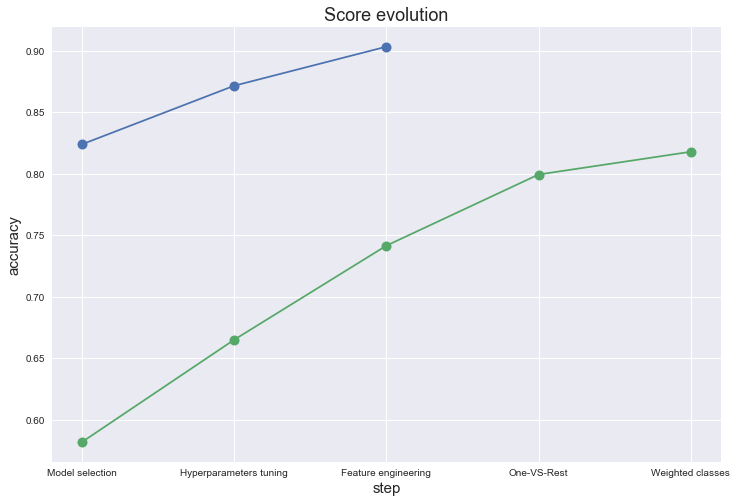

In [14]:
%matplotlib inline
plt.figure(figsize=[12, 8])
x=np.linspace(1,5,5)
plt.plot(x,df_stats[['CV acc','Kaggle score']],markersize=10,marker="o")
ticks=plt.xticks(x,df_stats['step'])
plt.ylabel("accuracy")
plt.xlabel("step")
plt.title("Score evolution")